In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time
import pickle
from imp import reload
from os.path import join

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from data_loader import DataLoader
import medim
reload(medim);

In [2]:
raw_path = '/home/mount/neuro-t01-hdd/Brats2017/data/raw/'

data_loader = DataLoader(raw_path)
patients = data_loader.patients

n_classes = 3

In [3]:
processed_path = '/mount/export/Brats2017/data/processed'
mscans = []
msegms = []

for patient in tqdm(patients):
    filename = join(processed_path, patient)
    
    mscans.append(np.load(filename+'_mscan.npy'))
    msegms.append(np.load(filename+'_segmentation.npy'))

100%|██████████| 285/285 [00:31<00:00,  3.74it/s]


In [4]:
n_splits = 50

cv = KFold(n_splits, shuffle=True, random_state=17)
train, val = next(cv.split(mscans))

def extract(l, idx):
    return [l[i] for i in idx]

mscans_train, mscans_val = extract(mscans, train), extract(mscans, val)
msegms_train, msegms_val = extract(msegms, train), extract(msegms, val)

In [7]:
def build_model(n_chans_for_each_layer, kernel_size):
    fe = []
    n_chans_prev = 4
    for n_chans in n_chans_for_each_layer[:-1]:
        c = nn.Conv3d(n_chans_prev, n_chans, kernel_size, bias=False)
        bn = nn.BatchNorm3d(n_chans)
        a = nn.ReLU()
        fe.extend([c, bn, a])
        n_chans_prev = n_chans
        
    n_chans = n_chans_for_each_layer[-1]
    c = nn.Conv3d(n_chans_prev, n_chans, kernel_size=1, bias=False)
    bn = nn.BatchNorm3d(n_chans)
    a = nn.Sigmoid()
    fe.extend([c, bn, a])

    return nn.Sequential(*fe)


class Model(torch.nn.Module):
    def __init__(self, n_chans_for_each_layer, kernel_size):
        super().__init__()
        self.model = build_model(n_chans_for_each_layer, kernel_size)
    
    def forward(self, input):
        model = self.model(input)
        return model

kernel_size = 3
n_chans_for_each_layer = [16, 1b6, 32, 32, 64, 64, 8, n_classes]

patch_size_x = np.array([25, 25, 25])
patch_size_y = patch_size_x - 2*(len(n_chans_for_each_layer) - 1)

model = Model(n_chans_for_each_layer, kernel_size).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Model (
  (model): Sequential (
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU ()
    (9): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (10): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU ()
    (12): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (13): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (14): ReLU ()
    (15): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (16): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (17): ReLU ()
    (18): Conv3d(64

In [8]:
padding = (patch_size_x - patch_size_y) // 2

def min_padding(mscan, padding):
    padding = np.array([0] + list(padding))
    padding = np.repeat(padding[:, None], 2, axis=1)
    
    return np.pad(mscan, padding, mode='minimum')

In [9]:
def pred_reshape(y):
    x = y.permute(0, 2, 3, 4, 1)
    return x.contiguous().view(-1, x.size()[-1])

def loss_cross_entropy(y_pred, y_true):
    return F.cross_entropy(pred_reshape(y_pred), y_true.view(-1))

def loss_binary_entropy(y_pred, y_true):
    return F.binary_cross_entropy(y_pred, y_true)

def to_var(x, volatile=False):
    return Variable(torch.from_numpy(x), volatile=volatile).cuda()

def to_numpy(x):
    return x.cpu().data.numpy()

coeff = to_var(np.array([1, 2, 3], dtype=np.float32))
epsilon = 1e-7

def dice_loss(y_pred, target):
    y_pred = y_pred.view(*y_pred.size()[:2], -1)
    target = target.view(*target.size()[:2], -1)
    
#     s = y_pred.size()
#     e = epsilon.expand(s[0], 1, s[2])
    dice_scores = 2 * (epsilon + (y_pred * target).sum(2)) / \
                  (y_pred.sum(2) + target.sum(2) + 2 * epsilon)
        
    dice_scores = dice_scores.mean(0)
    dice_scores = dice_scores.view(-1)

    return -torch.sum(dice_scores * coeff)

def dice_score(y_pred, target):
    """Dice score for binary segmentation on 3d scan"""
    return 2 * np.sum(y_pred * target) / (np.sum(y_pred) + np.sum(target))

In [10]:
n_epoch = 100
batch_per_epoch = 40
batch_size = 128

for epoch in range(n_epoch):
    train_iter = medim.batch_iter.patch.uniform(
        mscans_train, msegms_train, batch_size=batch_size,
        patch_size_x=patch_size_x, patch_size_y=patch_size_y, 
    )
    
    start_train = time.time()
    
    model.train()
    losses = []
    weights = []
    for _ in range(batch_per_epoch):
        x_batch, y_batch = next(train_iter)

        y_pred = model(to_var(x_batch))

        optimizer.zero_grad()
        loss = loss_binary_entropy(y_pred, to_var(y_batch))
        
        loss.backward()
        optimizer.step()

        losses.append(to_numpy(loss))
        weights.append(len(x_batch))
            
    train_loss = np.average(np.array(losses).flatten(), weights=weights)
    #train_acc = np.average(np.array(accs).flatten(), weights=weights)
    
    end_train = time.time()
    
    start_val = time.time()
    
    model.eval()
    losses = []
    dices = []
    for mscan, segm in tqdm(zip(mscans_val, msegms_val)):
        x_batch = min_padding(mscan, padding)[None, :]
        y_batch = np.array(segm[None, :], dtype=np.float32)
        y_pred = model(to_var(x_batch, volatile=True))

        loss = loss_binary_entropy(y_pred, to_var(y_batch))

        y_pred = to_numpy(y_pred)
        dices.append([dice_score(y_pred[0, k] > 0.5, y_batch[0, k]) for k in range(n_classes)])
        losses.append(to_numpy(loss))
    
    end_val = time.time()
    
    val_loss = np.mean(np.array(losses).flatten())
    val_dices = np.mean(np.array(dices), axis=0)
    
    print('Epoch {}'.format(epoch))
    print('Train:', train_loss)
    print('Val  :', val_loss, val_dices)
    print('Time :', end_train - start_train, end_val - start_val)
    print('\n')

6it [00:08,  1.45s/it]


Epoch 0
Train: 0.673289366066
Val  : 0.705134 [ 0.60650284  0.47773615  0.17568301]
Time : 15.574271202087402 8.640097618103027




6it [00:08,  1.46s/it]


Epoch 1
Train: 0.650501148403
Val  : 0.660655 [ 0.69278332  0.40285913  0.58285033]
Time : 14.109190940856934 8.661710262298584




6it [00:08,  1.47s/it]


Epoch 2
Train: 0.623368033767
Val  : 0.615759 [ 0.74492425  0.50947751  0.6420837 ]
Time : 14.322998523712158 8.715915441513062




6it [00:08,  1.47s/it]


Epoch 3
Train: 0.60730753541
Val  : 0.593859 [ 0.68817428  0.47706939  0.58302464]
Time : 14.9179847240448 8.72293472290039




6it [00:08,  1.47s/it]


Epoch 4
Train: 0.589322270453
Val  : 0.575213 [ 0.71856491  0.5253782   0.64531227]
Time : 14.728667259216309 8.710729598999023




6it [00:08,  1.47s/it]


Epoch 5
Train: 0.569201090932
Val  : 0.581273 [ 0.78595625  0.59788751  0.63081113]
Time : 14.881773233413696 8.726194381713867




6it [00:08,  1.46s/it]


Epoch 6
Train: 0.551587493718
Val  : 0.543542 [ 0.71596254  0.50479268  0.64260506]
Time : 14.925416469573975 8.686777353286743




6it [00:08,  1.47s/it]


Epoch 7
Train: 0.53419149965
Val  : 0.563164 [ 0.73150542  0.554752    0.62979975]
Time : 14.934424638748169 8.697656631469727




6it [00:08,  1.47s/it]


Epoch 8
Train: 0.520560980588
Val  : 0.522922 [ 0.7060604   0.50137552  0.57339735]
Time : 14.974842548370361 8.772012710571289




6it [00:08,  1.47s/it]


Epoch 9
Train: 0.507449382544
Val  : 0.497521 [ 0.76545848  0.58022661  0.6580237 ]
Time : 15.00751519203186 8.757232904434204




6it [00:08,  1.47s/it]


Epoch 10
Train: 0.4900690943
Val  : 0.485409 [ 0.70302691  0.55610749  0.67762392]
Time : 14.997039318084717 8.779719591140747




6it [00:08,  1.47s/it]


Epoch 11
Train: 0.477068644017
Val  : 0.452756 [ 0.79129848  0.60516235  0.73476738]
Time : 15.008336544036865 8.7097749710083




6it [00:08,  1.47s/it]


Epoch 12
Train: 0.466104317456
Val  : 0.468069 [ 0.71183427  0.59403876  0.66747084]
Time : 14.951226949691772 8.78547191619873




6it [00:08,  1.47s/it]


Epoch 13
Train: 0.449574075639
Val  : 0.434029 [ 0.78778359  0.64223636  0.70581582]
Time : 15.029592990875244 8.741930484771729




6it [00:08,  1.47s/it]


Epoch 14
Train: 0.438003853709
Val  : 0.451721 [ 0.74148676  0.57973352  0.66739367]
Time : 14.979041576385498 8.728009700775146




6it [00:08,  1.47s/it]


Epoch 15
Train: 0.4254481785
Val  : 0.437874 [ 0.7338989   0.59826734  0.63798756]
Time : 15.00627589225769 8.745275259017944




6it [00:08,  1.47s/it]


Epoch 16
Train: 0.408580069989
Val  : 0.386405 [ 0.75042649  0.61891208  0.67324232]
Time : 14.990143060684204 8.752177715301514




6it [00:08,  1.47s/it]


Epoch 17
Train: 0.405744265765
Val  : 0.415478 [ 0.74820554  0.60567456  0.63610134]
Time : 15.006900787353516 8.74923062324524




6it [00:08,  1.47s/it]


Epoch 18
Train: 0.390571267158
Val  : 0.384899 [ 0.77391061  0.63579513  0.70244257]
Time : 15.009287357330322 8.764933586120605




6it [00:08,  1.48s/it]


Epoch 19
Train: 0.378388057649
Val  : 0.3809 [ 0.81454851  0.74651907  0.69779819]
Time : 14.98404574394226 8.77825140953064




6it [00:08,  1.47s/it]


Epoch 20
Train: 0.375420039892
Val  : 0.380368 [ 0.68034208  0.56235569  0.63499291]
Time : 14.988287448883057 8.755393028259277




6it [00:08,  1.47s/it]


Epoch 21
Train: 0.359229727834
Val  : 0.338723 [ 0.78276413  0.68045192  0.66965997]
Time : 14.976600646972656 8.763995170593262




6it [00:08,  1.47s/it]


Epoch 22
Train: 0.349537155032
Val  : 0.333564 [ 0.79708799  0.70178181  0.66739327]
Time : 14.965911626815796 8.723639726638794




6it [00:08,  1.47s/it]


Epoch 23
Train: 0.338494938612
Val  : 0.336812 [ 0.8266826   0.75980757  0.7305106 ]
Time : 15.06783652305603 8.75221848487854




6it [00:08,  1.47s/it]


Epoch 24
Train: 0.332719670981
Val  : 0.376559 [ 0.73450571  0.68045948  0.62653719]
Time : 14.966487407684326 8.753438711166382




6it [00:08,  1.47s/it]


Epoch 25
Train: 0.323518251628
Val  : 0.321381 [ 0.74999347  0.70854379  0.71380356]
Time : 14.972006797790527 8.74072265625




6it [00:08,  1.47s/it]


Epoch 26
Train: 0.312183506787
Val  : 0.32057 [ 0.81099244  0.71747953  0.70779368]
Time : 14.995312213897705 8.743776082992554




6it [00:08,  1.47s/it]


Epoch 27
Train: 0.307823206484
Val  : 0.289318 [ 0.81980778  0.7134044   0.67212031]
Time : 14.978822708129883 8.751534938812256




6it [00:08,  1.47s/it]


Epoch 28
Train: 0.298515476286
Val  : 0.29293 [ 0.76699549  0.65923992  0.69509675]
Time : 14.994884490966797 8.76519513130188




6it [00:08,  1.47s/it]


Epoch 29
Train: 0.291383289546
Val  : 0.295666 [ 0.81425126  0.75246508  0.72983166]
Time : 14.996017932891846 8.738008499145508




6it [00:08,  1.47s/it]


Epoch 30
Train: 0.286769302189
Val  : 0.276822 [ 0.80658459  0.78673392  0.71219543]
Time : 14.99087905883789 8.744884490966797




6it [00:08,  1.48s/it]


Epoch 31
Train: 0.280921632051
Val  : 0.295993 [ 0.80113065  0.77793153  0.73139507]
Time : 15.02054238319397 8.759928703308105




6it [00:08,  1.47s/it]


Epoch 32
Train: 0.276936676353
Val  : 0.265301 [ 0.79009209  0.79190661  0.73030414]
Time : 14.971662044525146 8.762174606323242




6it [00:08,  1.47s/it]


Epoch 33
Train: 0.264278976619
Val  : 0.277465 [ 0.82287553  0.80654815  0.72933209]
Time : 15.045894384384155 8.743591785430908




6it [00:08,  1.47s/it]


Epoch 34
Train: 0.258273806423
Val  : 0.264249 [ 0.80773588  0.65992947  0.7105379 ]
Time : 14.99002718925476 8.751132726669312




6it [00:08,  1.47s/it]


Epoch 35
Train: 0.259407268837
Val  : 0.244616 [ 0.79257158  0.72914751  0.67896881]
Time : 15.028782844543457 8.74560809135437




6it [00:08,  1.47s/it]


Epoch 36
Train: 0.250894088298
Val  : 0.256074 [ 0.7427851   0.71472117  0.70198231]
Time : 15.004254341125488 8.775441408157349




6it [00:08,  1.51s/it]


Epoch 37
Train: 0.249592695758
Val  : 0.29862 [ 0.74854844  0.59029531  0.62319718]
Time : 15.03590703010559 8.922755479812622




6it [00:08,  1.48s/it]


Epoch 38
Train: 0.238429817185
Val  : 0.241552 [ 0.79091433  0.69983114  0.72716411]
Time : 15.002709865570068 8.771097660064697




6it [00:08,  1.47s/it]


Epoch 39
Train: 0.235653049499
Val  : 0.232429 [ 0.80247261  0.80251842  0.7175531 ]
Time : 15.03446078300476 8.758171319961548




6it [00:08,  1.48s/it]


Epoch 40
Train: 0.230986537412
Val  : 0.229516 [ 0.80617415  0.76484262  0.70680517]
Time : 15.026071548461914 8.778508424758911




6it [00:08,  1.47s/it]


Epoch 41
Train: 0.225183303282
Val  : 0.219985 [ 0.7879114   0.72702531  0.64098362]
Time : 15.003689765930176 8.769741773605347




6it [00:08,  1.47s/it]


Epoch 42
Train: 0.21997076124
Val  : 0.237033 [ 0.82763372  0.76073709  0.66561372]
Time : 15.044338703155518 8.761822938919067




6it [00:08,  1.47s/it]


Epoch 43
Train: 0.212242461741
Val  : 0.224901 [ 0.80529229  0.7190089   0.70964089]
Time : 15.026695251464844 8.7483971118927




6it [00:08,  1.47s/it]


Epoch 44
Train: 0.209742661938
Val  : 0.226967 [ 0.80277332  0.79055486  0.72932756]
Time : 14.995138168334961 8.775208950042725




6it [00:08,  1.47s/it]


Epoch 45
Train: 0.205114331841
Val  : 0.205489 [ 0.79674329  0.78476123  0.73188855]
Time : 15.029622793197632 8.76567006111145




6it [00:08,  1.47s/it]


Epoch 46
Train: 0.200201184303
Val  : 0.186503 [ 0.79393425  0.77012353  0.74022638]
Time : 15.035994052886963 8.74997091293335




6it [00:08,  1.47s/it]


Epoch 47
Train: 0.194654199481
Val  : 0.210343 [ 0.79507969  0.78691413  0.73455767]
Time : 15.015332221984863 8.76511287689209




6it [00:08,  1.47s/it]


Epoch 48
Train: 0.191285016015
Val  : 0.195112 [ 0.81315766  0.78011369  0.75216303]
Time : 15.00567078590393 8.745388269424438




6it [00:08,  1.47s/it]


Epoch 49
Train: 0.188550750539
Val  : 0.196665 [ 0.83357357  0.77687618  0.72573241]
Time : 15.018273830413818 8.749236822128296




6it [00:08,  1.48s/it]


Epoch 50
Train: 0.181377966329
Val  : 0.194894 [ 0.82686032  0.78099861  0.74643904]
Time : 15.016625881195068 8.76748776435852




6it [00:08,  1.48s/it]


Epoch 51
Train: 0.177512682602
Val  : 0.204178 [ 0.83214316  0.81042069  0.75189112]
Time : 14.98829698562622 8.769752979278564




6it [00:08,  1.48s/it]


Epoch 52
Train: 0.173657055944
Val  : 0.190668 [ 0.83941058  0.81771984  0.75370388]
Time : 14.981366634368896 8.76746916770935




6it [00:08,  1.48s/it]


Epoch 53
Train: 0.172348566353
Val  : 0.185618 [ 0.82911522  0.81045966  0.7333866 ]
Time : 15.0202956199646 8.776895523071289




6it [00:08,  1.48s/it]


Epoch 54
Train: 0.169461246207
Val  : 0.158127 [ 0.80252327  0.74399161  0.73269087]
Time : 14.973556995391846 8.777911901473999




6it [00:08,  1.47s/it]


Epoch 55
Train: 0.165349501371
Val  : 0.154602 [ 0.83396786  0.75738227  0.72373645]
Time : 15.052475452423096 8.7538583278656




6it [00:08,  1.48s/it]


Epoch 56
Train: 0.16229217276
Val  : 0.159859 [ 0.82455366  0.79273905  0.74054491]
Time : 14.981274366378784 8.787235260009766




6it [00:08,  1.48s/it]


Epoch 57
Train: 0.161287030578
Val  : 0.147786 [ 0.80368086  0.80526786  0.73459119]
Time : 15.040724277496338 8.78648591041565




6it [00:08,  1.47s/it]


Epoch 58
Train: 0.157182201371
Val  : 0.178479 [ 0.83696651  0.82477618  0.73317029]
Time : 15.038441896438599 8.74170970916748




6it [00:08,  1.48s/it]


Epoch 59
Train: 0.15378517434
Val  : 0.143239 [ 0.82194805  0.77769977  0.74072148]
Time : 14.98256540298462 8.780161380767822




6it [00:08,  1.47s/it]


Epoch 60
Train: 0.150539486483
Val  : 0.137691 [ 0.81444532  0.74527082  0.69967914]
Time : 15.025553226470947 8.735445737838745




6it [00:08,  1.47s/it]


Epoch 61
Train: 0.147260002419
Val  : 0.164231 [ 0.82659091  0.78190944  0.76050168]
Time : 14.996962785720825 8.722857236862183




6it [00:08,  1.46s/it]


Epoch 62
Train: 0.147310587764
Val  : 0.130781 [ 0.82854716  0.66435125  0.56815081]
Time : 15.044721364974976 8.709075689315796




6it [00:08,  1.46s/it]


Epoch 63
Train: 0.144313444383
Val  : 0.158961 [ 0.83435012  0.80574663  0.74976619]
Time : 15.05429482460022 8.681854248046875




6it [00:08,  1.46s/it]


Epoch 64
Train: 0.134897964261
Val  : 0.14862 [ 0.8358034   0.82433015  0.756321  ]
Time : 15.042798042297363 8.684530258178711




6it [00:08,  1.46s/it]


Epoch 65
Train: 0.137215881608
Val  : 0.15627 [ 0.84315437  0.74315102  0.75124862]
Time : 15.040383577346802 8.699601888656616




6it [00:08,  1.47s/it]


Epoch 66
Train: 0.133717078343
Val  : 0.139753 [ 0.84175591  0.76067998  0.75073133]
Time : 15.001279830932617 8.722351312637329




6it [00:08,  1.46s/it]


Epoch 67
Train: 0.128420703486
Val  : 0.137543 [ 0.83876144  0.82911443  0.7712051 ]
Time : 15.026664972305298 8.702149152755737




6it [00:08,  1.47s/it]


Epoch 68
Train: 0.128938289359
Val  : 0.13079 [ 0.84972957  0.81261927  0.75341138]
Time : 15.022238731384277 8.711711645126343




6it [00:08,  1.47s/it]


Epoch 69
Train: 0.124999252707
Val  : 0.126829 [ 0.84603188  0.83113955  0.76959608]
Time : 15.040307998657227 8.711910963058472




KeyboardInterrupt: 

In [11]:
model.eval()

Model (
  (model): Sequential (
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU ()
    (9): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (10): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU ()
    (12): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (13): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (14): ReLU ()
    (15): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (16): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (17): ReLU ()
    (18): Conv3d(64

In [13]:
y_predicted = []

for mscan, segm in tqdm(zip(mscans_val, msegms_val)):
    x_batch = min_padding(mscan, padding)[None, :]
    y_batch = np.array(segm[None, :], dtype=np.float32)
    y_pred = model(to_var(x_batch, volatile=True))

    y_predicted.append(to_numpy(y_pred)[0])

6it [00:08,  1.44s/it]


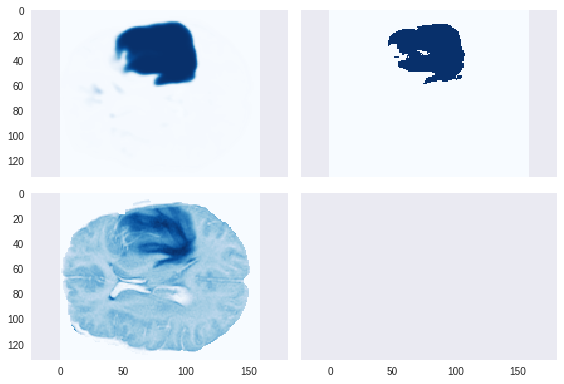

In [38]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

i = 1
k = 80

cmap = cm.Blues

ax[0, 0].imshow(y_predicted[i][0, ..., k], cmap=cmap)
#plt.colorbar()
#plt.show()
ax[0, 1].imshow(msegms_val[i][0, ..., k], cmap=cmap)
ax[1, 0].imshow(mscans_val[i][3, ..., k], cmap=cmap)
plt.tight_layout()
plt.show()
#plt.colorbar()
#plt.show()

In [13]:
plt.imshow(to_numpy(model(to_var(x_batch, volatile=True)))[0, 0, ..., 10])

RuntimeError: cuda runtime error (2) : out of memory at /py/conda-bld/pytorch_1493680494901/work/torch/lib/THC/THCGeneral.c:833

In [133]:
np.sum(e == np.zeros_like(e)) / np.prod(e.shape)

1.0

In [131]:
e = np.argmax(to_numpy(pred_reshape(y_pred)), axis=1)

In [134]:
e

array([0, 0, 0, ..., 0, 0, 0])

In [55]:
def one_hot(x):
    enc = np.eye(n_classes)[x]
    return np.rollaxis(enc, 4, 1)

In [62]:
np.unique(y_batch, return_counts=True)

(array([0, 2]), array([6621,  669]))

In [67]:
np.all(one_hot(y_batch).sum(1) == 1)

True

In [113]:
a = one_hot(y_batch)

In [114]:
np.mean(np.argmax(a, axis=1) == y_batch)

1.0

In [112]:
a.shape

(10, 4, 9, 9, 9)

In [115]:
b = pred_reshape(to_var(a))

In [116]:
b.size()

torch.Size([7290, 4])

In [123]:
F.cross_entropy(b*10, to_var(y_batch.flatten()).long())

Variable containing:
1.00000e-04 *
  1.3619
[torch.cuda.DoubleTensor of size 1 (GPU 0)]

In [8]:
def to_vec(y):
    return y.reshape((1,))

In [79]:
y = np.arange(8).reshape((2,2,2))

In [80]:
x = torch.randn(2, 3, 5)

In [46]:
s = x.size()

In [37]:
a = x.permute(2, 0, 1).size()

In [54]:
s

torch.Size([2, 3, 5])

In [43]:
np.prod(a[:2])

10

In [52]:
x = x.view(int(np.prod((x.size()[:2]))), x.size()[-1])

In [53]:
x.size()

torch.Size([6, 5])